In [307]:
from PIL.ExifTags import TAGS
import pathlib
import csv
import glob
from PIL import Image
import pandas as pd
import os
from datetime import time
from matplotlib import markers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib
import seaborn as sns
import glob
from seaborn import palettes
from seaborn.categorical import swarmplot
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import json
from scipy.signal import detrend
from scipy.ndimage import gaussian_filter1d
from skimage.color import rgb2gray
import os
import re
import math
import matplotlib.ticker as tck
import argparse
import cv2
import skimage as ski
from matplotlib.ticker import ScalarFormatter


Loading csv file with grouped by measurement_id and well_id

In [378]:
path = 'C:/Users/srboval1/OneDrive - Aalto University/Instru/Datafiles/Exp2'
Exp2 = pd.read_csv(path +'/contours_exp2.csv', index_col=None)
print(Exp2.columns)

Index(['Unnamed: 0', 'ID_running', 'time_id', 'incubation_time',
       'area_pixels**2', 'area_µm', 'normalized_area_µm', 'perimeter_µm',
       'compactness', 'aspect_ratio', 'convex hull perimeter',
       'convex hull area', 'convexity_perimeter', 'convexity_area', 'well_id',
       'measurement_id', 'cell_line', 'matrix', 'date', 'grouped_id',
       'spheroid_ID', 'growth_rate_%'],
      dtype='object')


Unique materials and cell lines

In [364]:
unique_materials_check = Exp2['matrix'].unique()
unique_materials = ['collagen', 'IPN3mM', 'IPN22mM']

if set(unique_materials) == set(unique_materials_check):
    print("The custom order contains all and only the elements in unique_materials.")
else:
    print("Mismatch detected between custom_order and unique_materials.")

unique_lines = Exp2['cell_line'].unique()

The custom order contains all and only the elements in unique_materials.


In [365]:
for material in unique_materials:
    for line in unique_lines:
        subset = Exp2[(Exp2['matrix'] == material) & (Exp2['cell_line'] == line)]
        duplicates = subset.duplicated(subset=['grouped_id'])
        if duplicates.any():
            print(f"Duplicate grouped_id found for {material} and {line}")


Duplicate grouped_id found for collagen and MCF10A
Duplicate grouped_id found for collagen and DCIS.COM
Duplicate grouped_id found for IPN3mM and MCF10A
Duplicate grouped_id found for IPN3mM and DCIS.COM
Duplicate grouped_id found for IPN3mM and MCF10AT
Duplicate grouped_id found for IPN22mM and MCF10A
Duplicate grouped_id found for IPN22mM and DCIS.COM
Duplicate grouped_id found for IPN22mM and MCF10AT


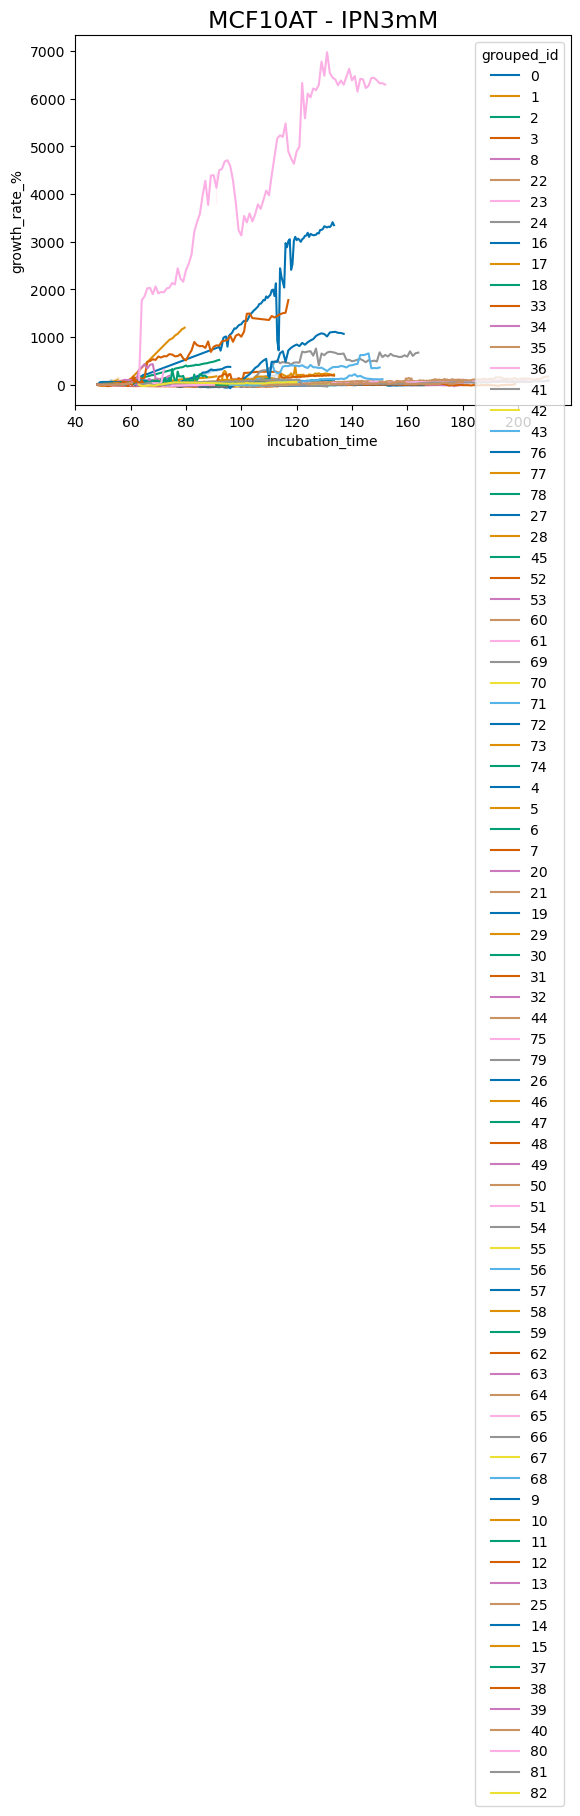

In [398]:
linda = Exp2
linda['grouped_id'] = linda.groupby(['measurement_id', 'well_id','cell_line','matrix']).ngroup()


for labels,data in linda.groupby(['cell_line','matrix']):
    sns.lineplot(data=data, y='growth_rate_%', x='incubation_time', hue='grouped_id', palette='colorblind')
    plt.title(f'{labels[0]} - {labels[1]}', fontsize=17)




c:\Users\srboval1\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\srboval1\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\srboval1\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\srboval1\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\srboval1\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\srboval1\AppData\L

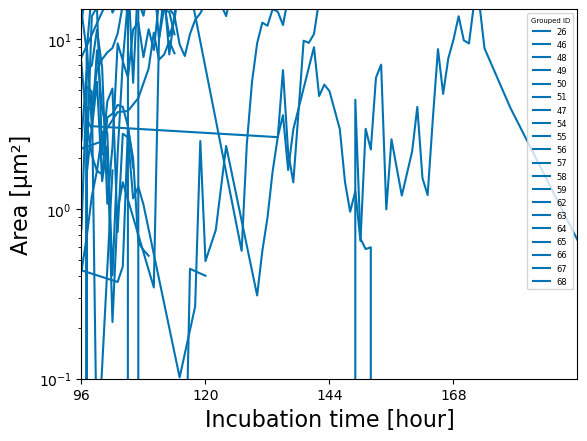

In [399]:
for i in linda['grouped_id'].unique():
    x = linda[(linda['grouped_id']==i)]  
    if x['cell_line'].unique() == 'MCF10A': 
        if x['matrix'].unique() == 'collagen':
            min_value_all = (x['incubation_time'].min() // 24) * 24  # latest end of timelapses x_max
            max_value_all = (x['incubation_time'].max() // 24 + 2) * 24  # latest end of timelapses x_max
            times = list(np.arange(min_value_all, max_value_all, 24))  # ticks' values

            sns.lineplot(data=x, y='growth_rate_%', x='incubation_time', hue='grouped_id', palette='colorblind')
          
          
            plt.xlim(min_value_all, max_value_all)
            plt.yscale('log')
            plt.ylabel('Area [µm²]', fontsize=16)
            plt.xlabel('Incubation time [hour]', fontsize=16)
#            sns.set_title(f'{unique_material} - {unique_line}', fontsize=17)
            plt.ylim(0.1, 15)
            plt.xticks(times)
            plt.legend(title='Grouped ID', fontsize=6, title_fontsize=5, loc='best')


C:\Users\srboval1\AppData\Local\Temp\ipykernel_9836\1197871859.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  specific_df_grp = specific_df.groupby(['cell_line','incubation_time']).mean()
C:\Users\srboval1\AppData\Local\Temp\ipykernel_9836\1197871859.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  specific_df_grp = specific_df.groupby(['cell_line','incubation_time']).mean()
C:\Users\srboval1\AppData\Local\Temp\ipykernel_9836\1197871859.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specif

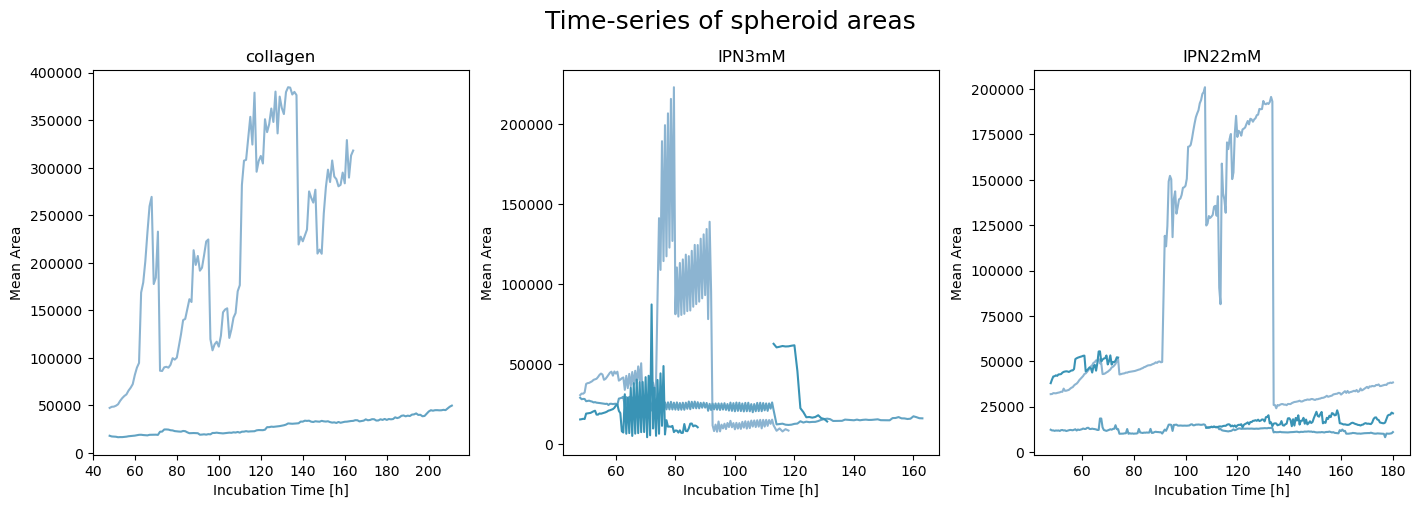

In [368]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(17,5))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
fig.suptitle("Time-series of spheroid areas", fontsize=18, y=1)

for i,unique_material in enumerate(unique_materials):
    specific_df = Exp2[Exp2['matrix'] == unique_material]
    specific_df_grp = specific_df.groupby(['cell_line','incubation_time']).mean()
    #print(specific_df_grp.head())
    ax=axs[i]
    ax.plot(specific_df_grp.unstack(0)['area_µm']) # area as a function of incubation time, for each cell line
    ax.set_xlabel('Incubation Time [h]')  
    ax.set_ylabel('Mean Area')        
    ax.set_title(unique_material)




Relative growth of spheroids

C:\Users\srboval1\AppData\Local\Temp\ipykernel_9836\3687943868.py:21: UserWarning: 
The palette list has fewer values (12) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=specific_specific_df, y='growth_rate_%', x='incubation_time', hue='grouped_id', ax=ax, legend= True, palette=palette, linewidth=1)
C:\Users\srboval1\AppData\Local\Temp\ipykernel_9836\3687943868.py:21: UserWarning: 
The palette list has fewer values (12) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=specific_specific_df, y='growth_rate_%', x='incubation_time', hue='grouped_id', ax=ax, legend= True, palette=palette, linewidth=1)
C:\Users\srboval1\AppData\Local\Temp\ipykernel_9836\3687943868.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=specific_specific_df, y='growth_rate_%', x='incubation_time', hue='grouped_id', ax=ax, legend= True, palette=palette, linewidth=1)
No

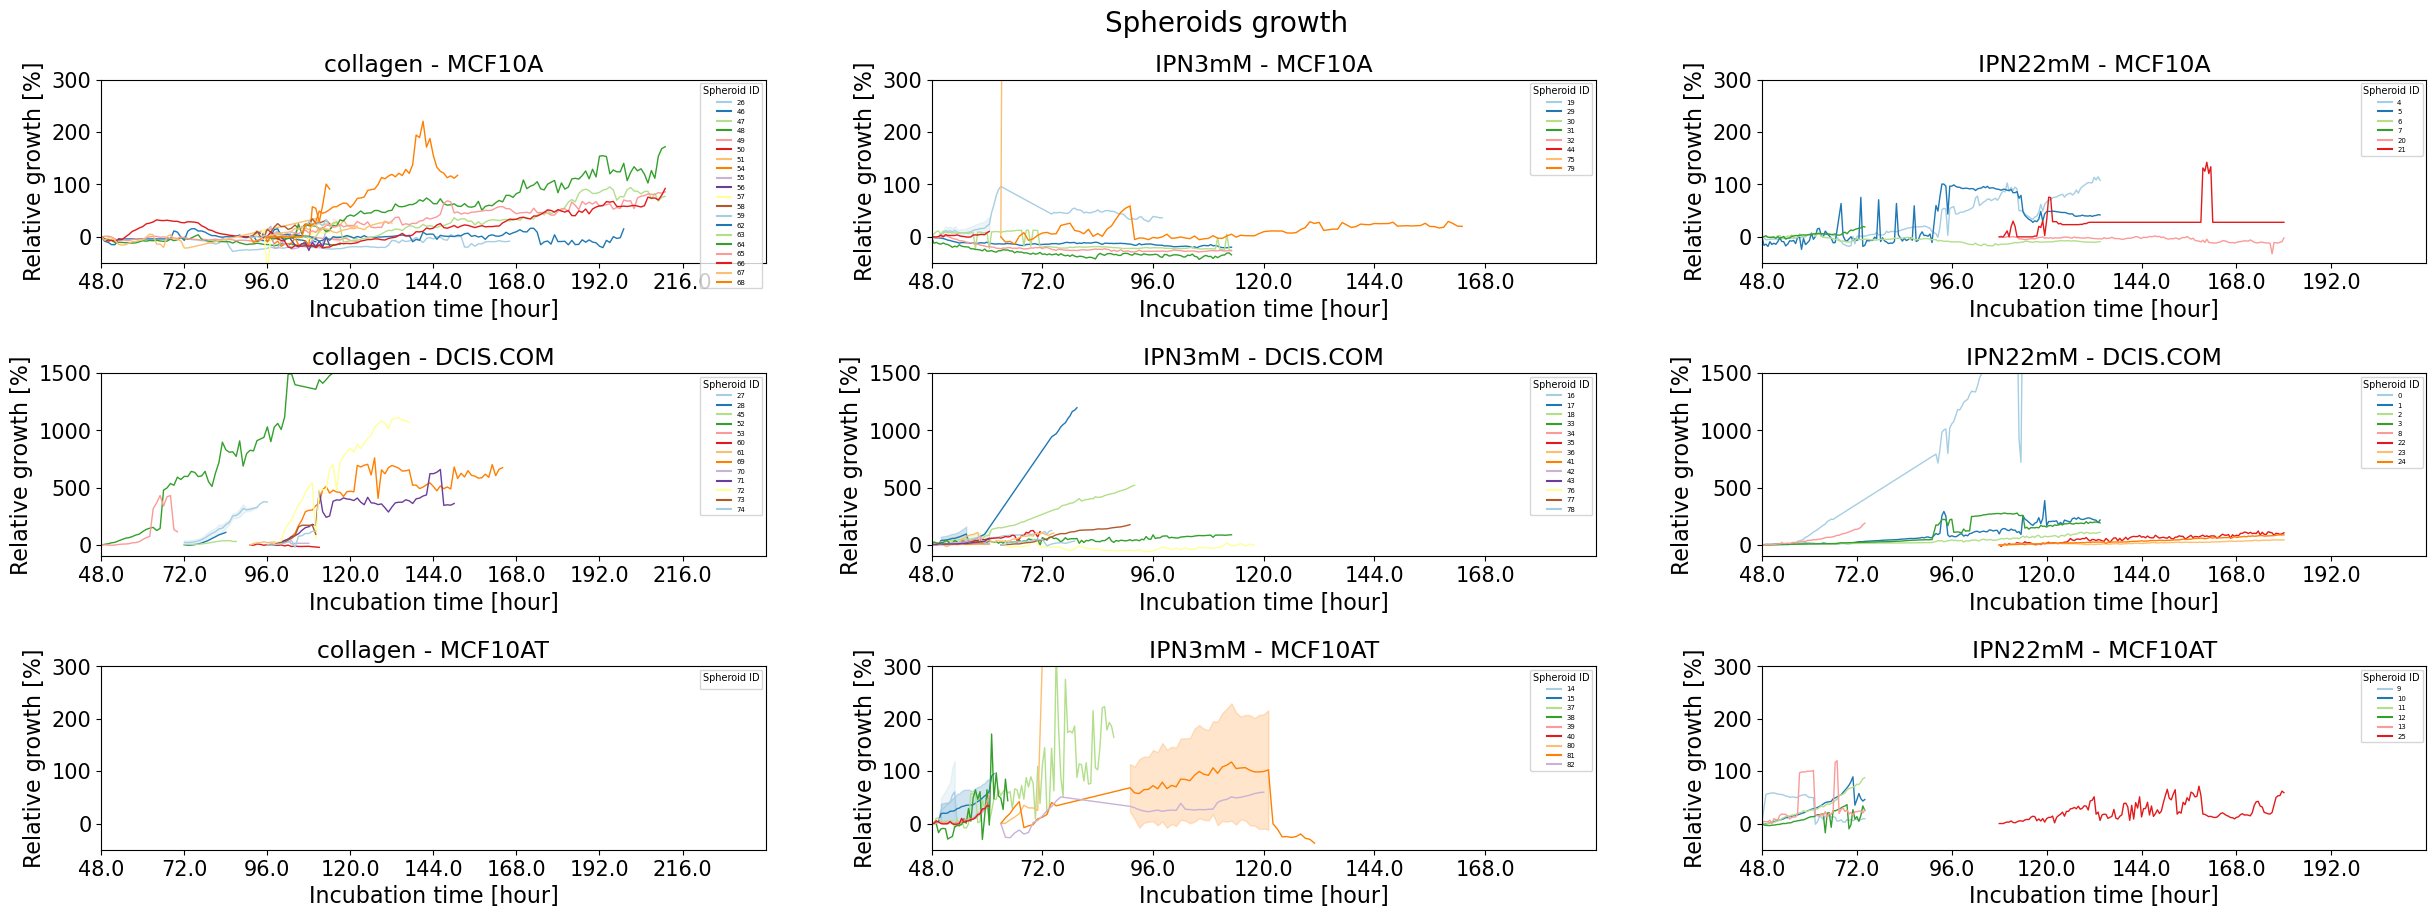

In [380]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, len(unique_materials), figsize=(30, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)
fig.suptitle("Spheroids growth", fontsize=20, y=0.95)

for i, unique_material in enumerate(unique_materials):
    specific_df = Exp2[(Exp2['matrix'] == unique_material) & (Exp2['area_µm'] > 0)]

    min_value_all = (specific_df['incubation_time'].min() // 24) * 24  # first time of timelapses x_min
    max_value_all = (specific_df['incubation_time'].max() // 24 + 2) * 24  # latest end of timelapses x_max

    times = list(np.arange(min_value_all, max_value_all, 24))  # ticks' values
    
    for j, unique_line in enumerate(unique_lines):
        ax = axs[j, i]
        specific_specific_df = specific_df[specific_df['cell_line'] == unique_line]

        palette = sns.color_palette("Paired")
        sns.lineplot(data=specific_specific_df, y='growth_rate_%', x='incubation_time', hue='grouped_id', ax=ax, legend= True, palette=palette, linewidth=1)
               
        f = specific_specific_df['grouped_id'].unique() #extracting labels for the specific df
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(labels = np.sort(f).astype(str).tolist(),handles=handles,title='Spheroid ID', fontsize=5, title_fontsize=7, bbox_to_anchor=(1, 1))

        ax.set_xlim(min_value_all, max_value_all)
        #ax.set_yscale('log')
        ax.set_ylabel('Relative growth [%]', fontsize=16)
        ax.set_xlabel('Incubation time [hour]', fontsize=16)
        ax.set_title(f'{unique_material} - {unique_line}', fontsize=17)
        if unique_line =='DCIS.COM':
            ax.set_ylim(-100, 1500)
        else:
            ax.set_ylim(-50, 300)
        ax.set_xticks(times)
        ax.set_xticklabels(times)
        ax.tick_params(axis='both', which='major', labelsize=15)

plt.savefig(path +'/Time_series.png',dpi=1000)

Average relative growth

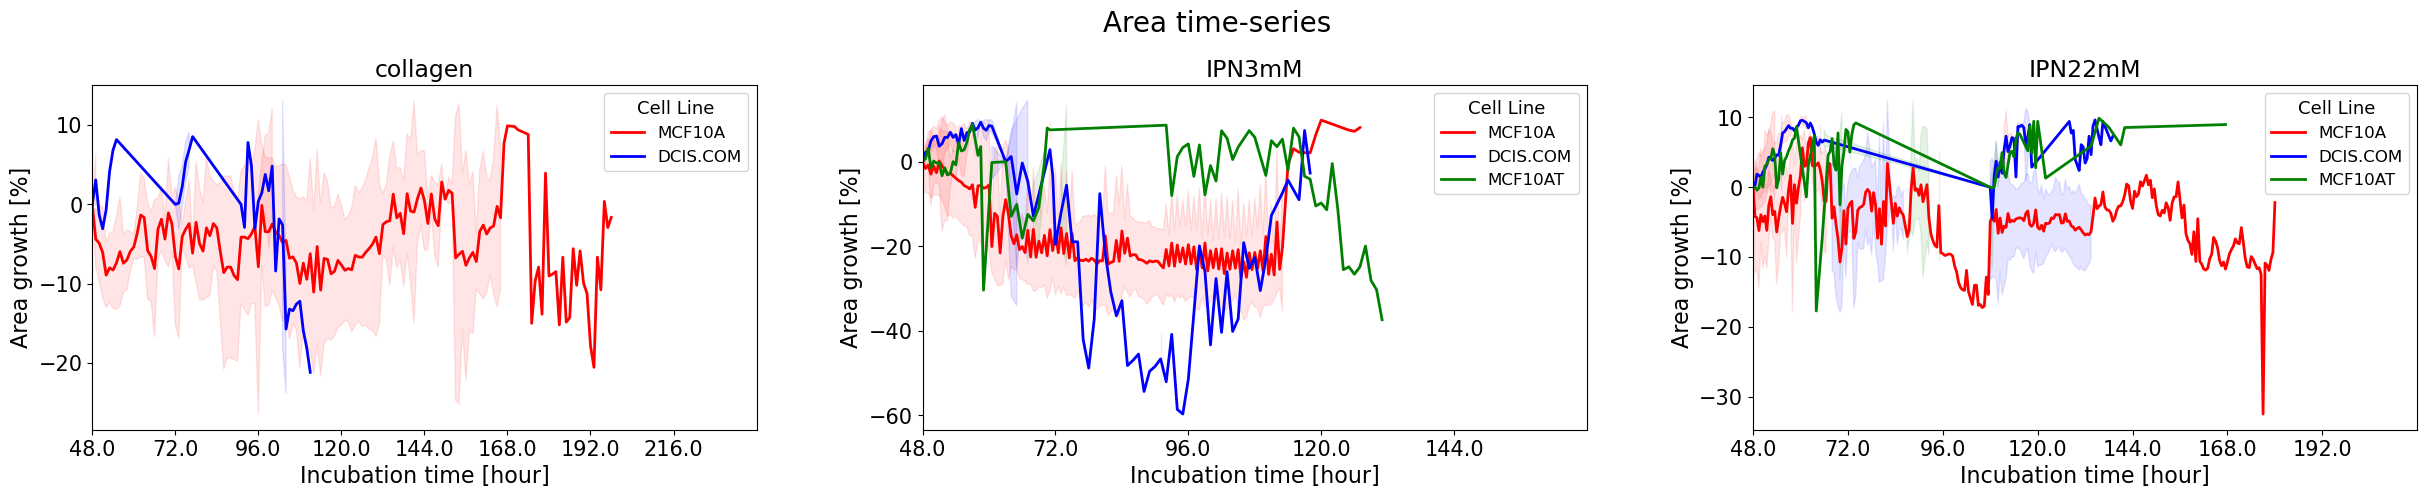

In [379]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the figure and axes
fig, axs = plt.subplots(1, len(unique_materials), figsize=(30, 5))
plt.subplots_adjust(wspace=0.25, top=0.8)
fig.suptitle("Area time-series", fontsize=20, y=0.95)

# Define a color palette for different lines
palette = ['red','blue','green'
]

for i, unique_material in enumerate(unique_materials):
    # Filter DataFrame for the current material
    specific_df = Exp2[(Exp2['matrix'] == unique_material) & 
                       (Exp2['area_µm'] > 0) & 
                       (Exp2['growth_rate_%'] < 10)]

    # Determine min and max incubation times
    min_value_all = (specific_df['incubation_time'].min() // 24) * 24
    max_value_all = (specific_df['incubation_time'].max() // 24 + 2) * 24
    times = list(np.arange(min_value_all, max_value_all, 24))

    # Create a single plot for all cell lines
    ax = axs[i]  # Use the first row for all cell lines of the current material

    for j, unique_line in enumerate(unique_lines):
        # Filter DataFrame for the current cell line
        specific_specific_df = specific_df[specific_df['cell_line'] == unique_line]

        # Group by 'incubation_time' to calculate mean and standard deviation
        grouped_mean = specific_specific_df.groupby('incubation_time')['growth_rate_%'].mean().reset_index()
        grouped_std = specific_specific_df.groupby('incubation_time')['growth_rate_%'].std().reset_index()

        # Plot mean line for the current cell line
        sns.lineplot(x=grouped_mean['incubation_time'], 
                     y=grouped_mean['growth_rate_%'], 
                     ax=ax, 
                     color=palette[j],  # Different color for each line
                     linestyle='-', 
                     linewidth=2, 
                     label=unique_line)  # Add legend for each line

        # Fill between for the standard deviation
        ax.fill_between(
            grouped_mean['incubation_time'],
            grouped_mean['growth_rate_%'] - grouped_std['growth_rate_%'],
            grouped_mean['growth_rate_%'] + grouped_std['growth_rate_%'],
            color=palette,
            alpha=0.1
        )

    # Set the limits and labels for the axes
    ax.set_xlim(min_value_all, max_value_all)
    ax.set_ylabel('Area growth [%]', fontsize=16)
    ax.set_xlabel('Incubation time [hour]', fontsize=16)
    ax.set_title(f'{unique_material}', fontsize=17)  # Title just for material
    #ax.set_ylim(0, 8)
    ax.set_xticks(times)
    ax.set_xticklabels(times)
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Add a legend for unique lines
    ax.legend(title='Cell Line', fontsize=12, title_fontsize=13)

# Save the figure
plt.savefig(path + 'Area growth.png', dpi=1000)


In [240]:
print(Exp2.columns)

Index(['Unnamed: 0', 'ID_running', 'time_id', 'incubation_time',
       'area_pixels**2', 'area_µm', 'normalized_area_µm', 'perimeter_µm',
       'compactness', 'aspect_ratio', 'convex hull perimeter',
       'convex hull area', 'convexity_perimeter', 'convexity_area', 'well_id',
       'measurement_id', 'cell_line', 'matrix', 'date', 'grouped_id',
       'spheroid_ID', 'growth_rate'],
      dtype='object')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


collagen   cell_line          mean        median           std
0  DCIS.COM  47307.975968  47307.975968  17837.638235
1    MCF10A  18014.621778  16523.270992   3798.412871
IPN3mM   cell_line          mean        median           std
0  DCIS.COM  30658.276489  37631.535121  16519.426163
1    MCF10A  29006.994973  26252.535595  13522.095661
2   MCF10AT  15423.774455  18856.229469   8588.586299
IPN22mM   cell_line          mean        median          std
0  DCIS.COM  31899.736309  28748.685600  8131.524976
1    MCF10A  12278.107199  10978.131349  3894.046519
2   MCF10AT  37935.821524  35408.471261  7935.781157


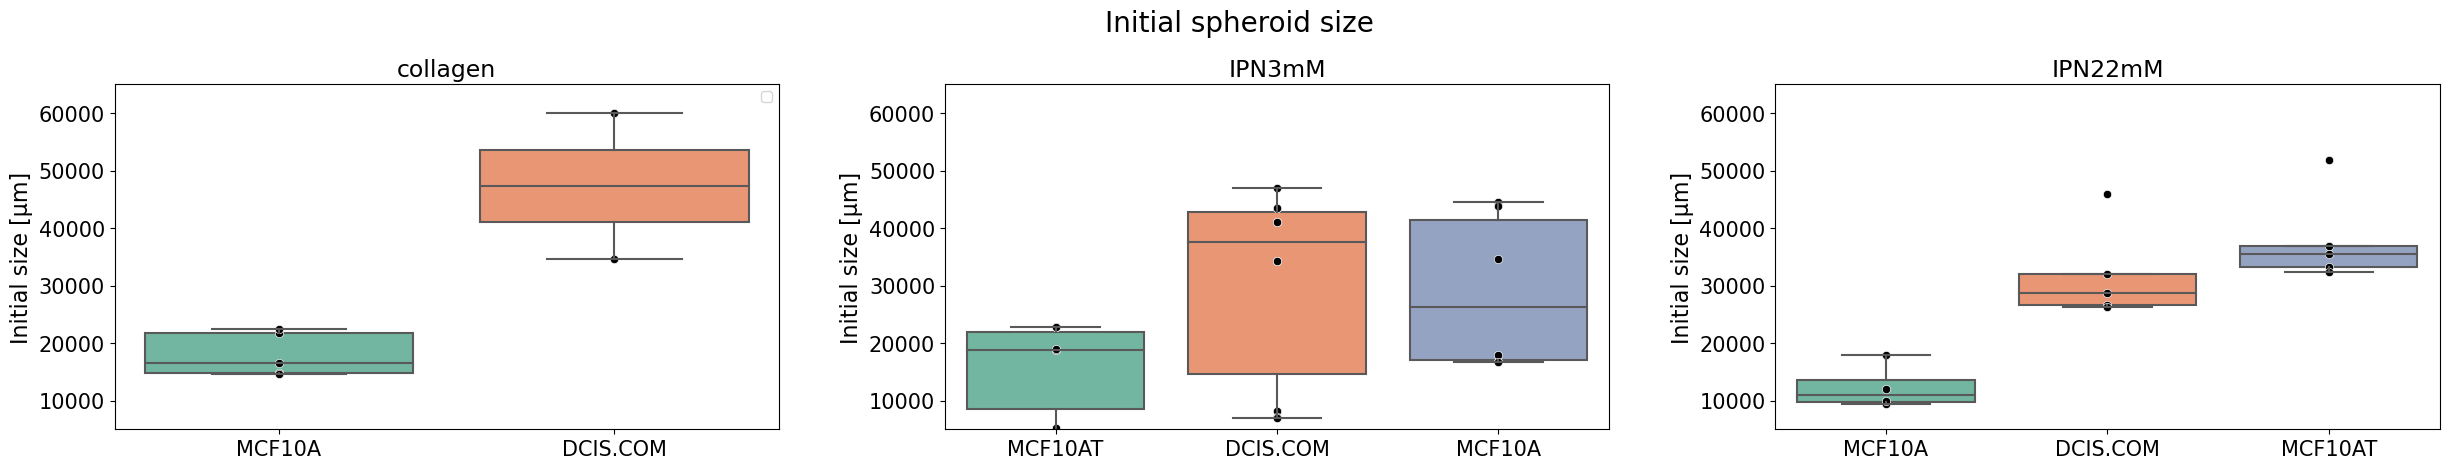

In [373]:

# Set up the figure and axes
fig, axs = plt.subplots(1, len(unique_materials), figsize=(30, 5))
plt.subplots_adjust(wspace=0.25, top=0.8)
fig.suptitle("Initial spheroid size", fontsize=20, y=0.95)

# Define a color palette for different lines
palette = ['red','blue','green'
]

for i, unique_material in enumerate(unique_materials):
    # Filter DataFrame for the current material
    specific_df = Exp2[(Exp2['matrix'] == unique_material) & 
                       (Exp2['area_µm'] > 0) &
                       (Exp2['incubation_time'] == 48.)]

    ax = axs[i]  # Use the first row for all cell lines of the current material

    
    result = specific_df.groupby('cell_line')['area_µm'].agg(['mean', 'median', 'std']).reset_index()
    print(unique_material, result)
    # Plot the boxplot
    sns.boxplot(x='cell_line', y='area_µm', data=specific_df, ax=axs[i], palette='Set2', showfliers = False)
    sns.scatterplot(x=specific_df['cell_line'], y=specific_df['area_µm'], ax=axs[i], color = 'black')


    # Plot the means as points
#    axs[i].plot(result['cell_line'], result['mean'], color='red', marker='o', linestyle='', label='Mean')
    

    axs[i].set_ylabel('Initial size [µm]', fontsize=16)
    axs[i].set_xlabel('', fontsize=16)
    axs[i].set_title(f'{unique_material}', fontsize=17)  # Title just for material
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    axs[i].set_ylim(5000,65000)


# Show the legend
axs[0].legend()

# Save the figure
plt.savefig(path + '/Spheroid_size_matrix.png', dpi=1000)

  cell_line          mean        median           std
0  DCIS.COM  32982.199904  34240.467792  14809.227815
1    MCF10A  20881.833835  16659.632524  11182.730135
2   MCF10AT  25656.523123  22827.922458  14152.336490


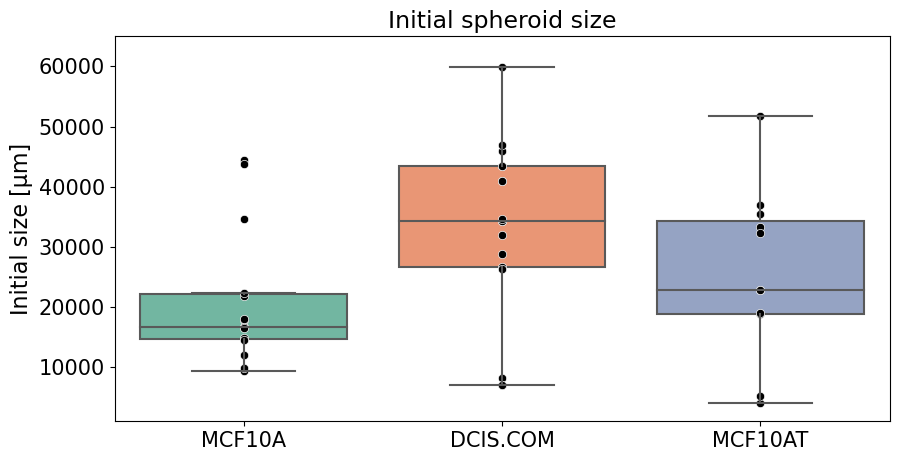

In [395]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

palette = ['red','blue','green']

specific_df = Exp2[(Exp2['area_µm'] > 0) & (Exp2['incubation_time'] == 48.)]

result = specific_df.groupby('cell_line')['area_µm'].agg(['mean', 'median', 'std']).reset_index()
print(result)

sns.boxplot(x='cell_line', y='area_µm', data=specific_df, palette='Set2', showfliers = False)
sns.scatterplot(x=specific_df['cell_line'], y=specific_df['area_µm'], color = 'black')

plt.ylabel('Initial size [µm]', fontsize=16)
plt.xlabel('', fontsize=16)
plt.title('Initial spheroid size', fontsize=17)  # Title just for material
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(1000,65000)

plt.savefig(path + '/Spheroid_size.png', dpi=1000)


  cell_line        median          std
0  DCIS.COM  28748.685600  8131.524976
1    MCF10A  10978.131349  3894.046519
2   MCF10AT  35408.471261  7935.781157
  cell_line        median           std
0  DCIS.COM  37631.535121  16519.426163
1    MCF10A  26252.535595  13522.095661
2   MCF10AT  18856.229469   8588.586299
  cell_line        median           std
0  DCIS.COM  47307.975968  17837.638235
1    MCF10A  16523.270992   3798.412871


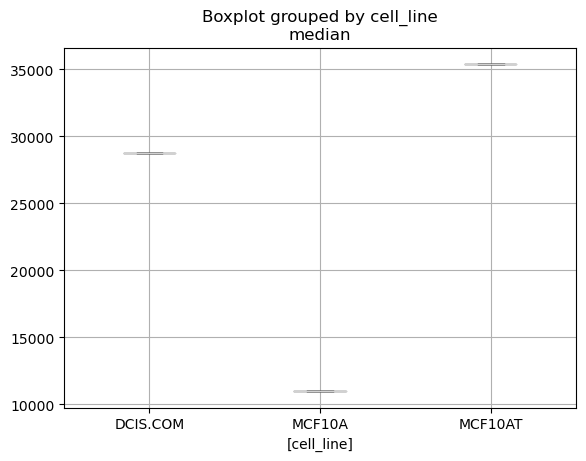

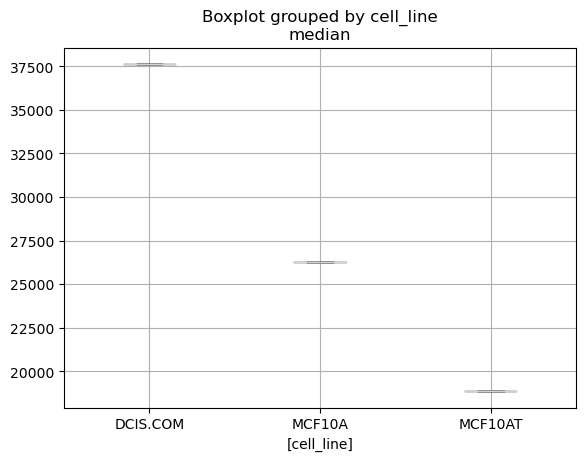

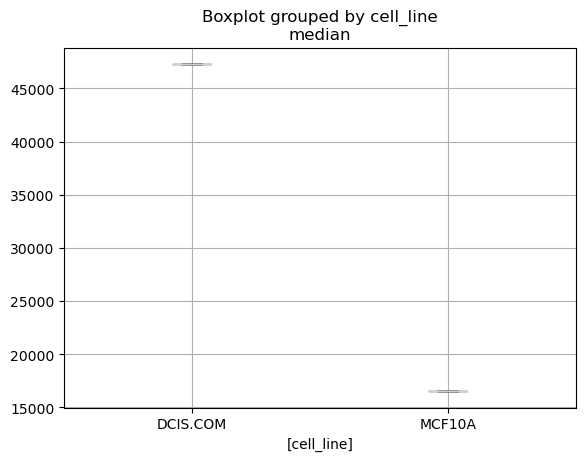

In [334]:

for i, unique_material in enumerate(unique_materials):
    # Filter DataFrame for the current material
    specific_df = Exp2[(Exp2['matrix'] == unique_material) & 
                       (Exp2['area_µm'] > 0) &
                       (Exp2['incubation_time'] == 48.)]

    ax = axs[i]  # Use the first row for all cell lines of the current material
    # Group by 'incubation_time' to calculate mean and standard deviation
    result = specific_df.groupby('cell_line')['area_µm'].agg(['median', 'std']).reset_index()
    result.boxplot(column=['median'], by=['cell_line'])



    print(result)


In [292]:
print(mean.dtype())

AttributeError: 'function' object has no attribute 'dtype'

In [268]:
for i, unique_material in enumerate(unique_materials):
    # Filter DataFrame for the current material
    specific_df = Exp2[(Exp2['matrix'] == unique_material) & 
                       (Exp2['area_µm'] > 0)]

    ax = axs[i]  # Use the first row for all cell lines of the current material

    for j, unique_line in enumerate(unique_lines):
        # Filter DataFrame for the current cell line
        specific_specific_df = specific_df[(specific_df['cell_line'] == unique_line) & (specific_df['incubation_time'] == 48.)]
        print(specific_specific_df)

      Unnamed: 0  ID_running  time_id  incubation_time  area_pixels**2  \
0              0           0        1             48.0         40904.5   
1409        1409          20        1             48.0         21336.5   
1578        1578          21        1             48.0         22711.5   
1747        1747          22        1             48.0         27611.5   

           area_µm  normalized_area_µm  perimeter_µm    compactness  \
0     17846.907925                 1.0    534.218777  224270.859312   
1409   9309.258173                 1.0    364.503464  116983.588351   
1578   9909.179903                 1.0    385.812253  124522.427148   
1747  12047.082795                 1.0    414.626359  151388.107223   

      aspect_ratio  ...  convexity_perimeter  convexity_area  well_id  \
0         1.357052  ...             0.929955        1.030938        3   
1409      1.103226  ...             0.951791        1.007944        4   
1578      0.982036  ...             0.947118        1.

c:\Users\srboval1\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\srboval1\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\srboval1\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\srboval1\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\srboval1\AppData\Local\anac

AttributeError: 'NoneType' object has no attribute 'remove'

c:\Users\srboval1\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


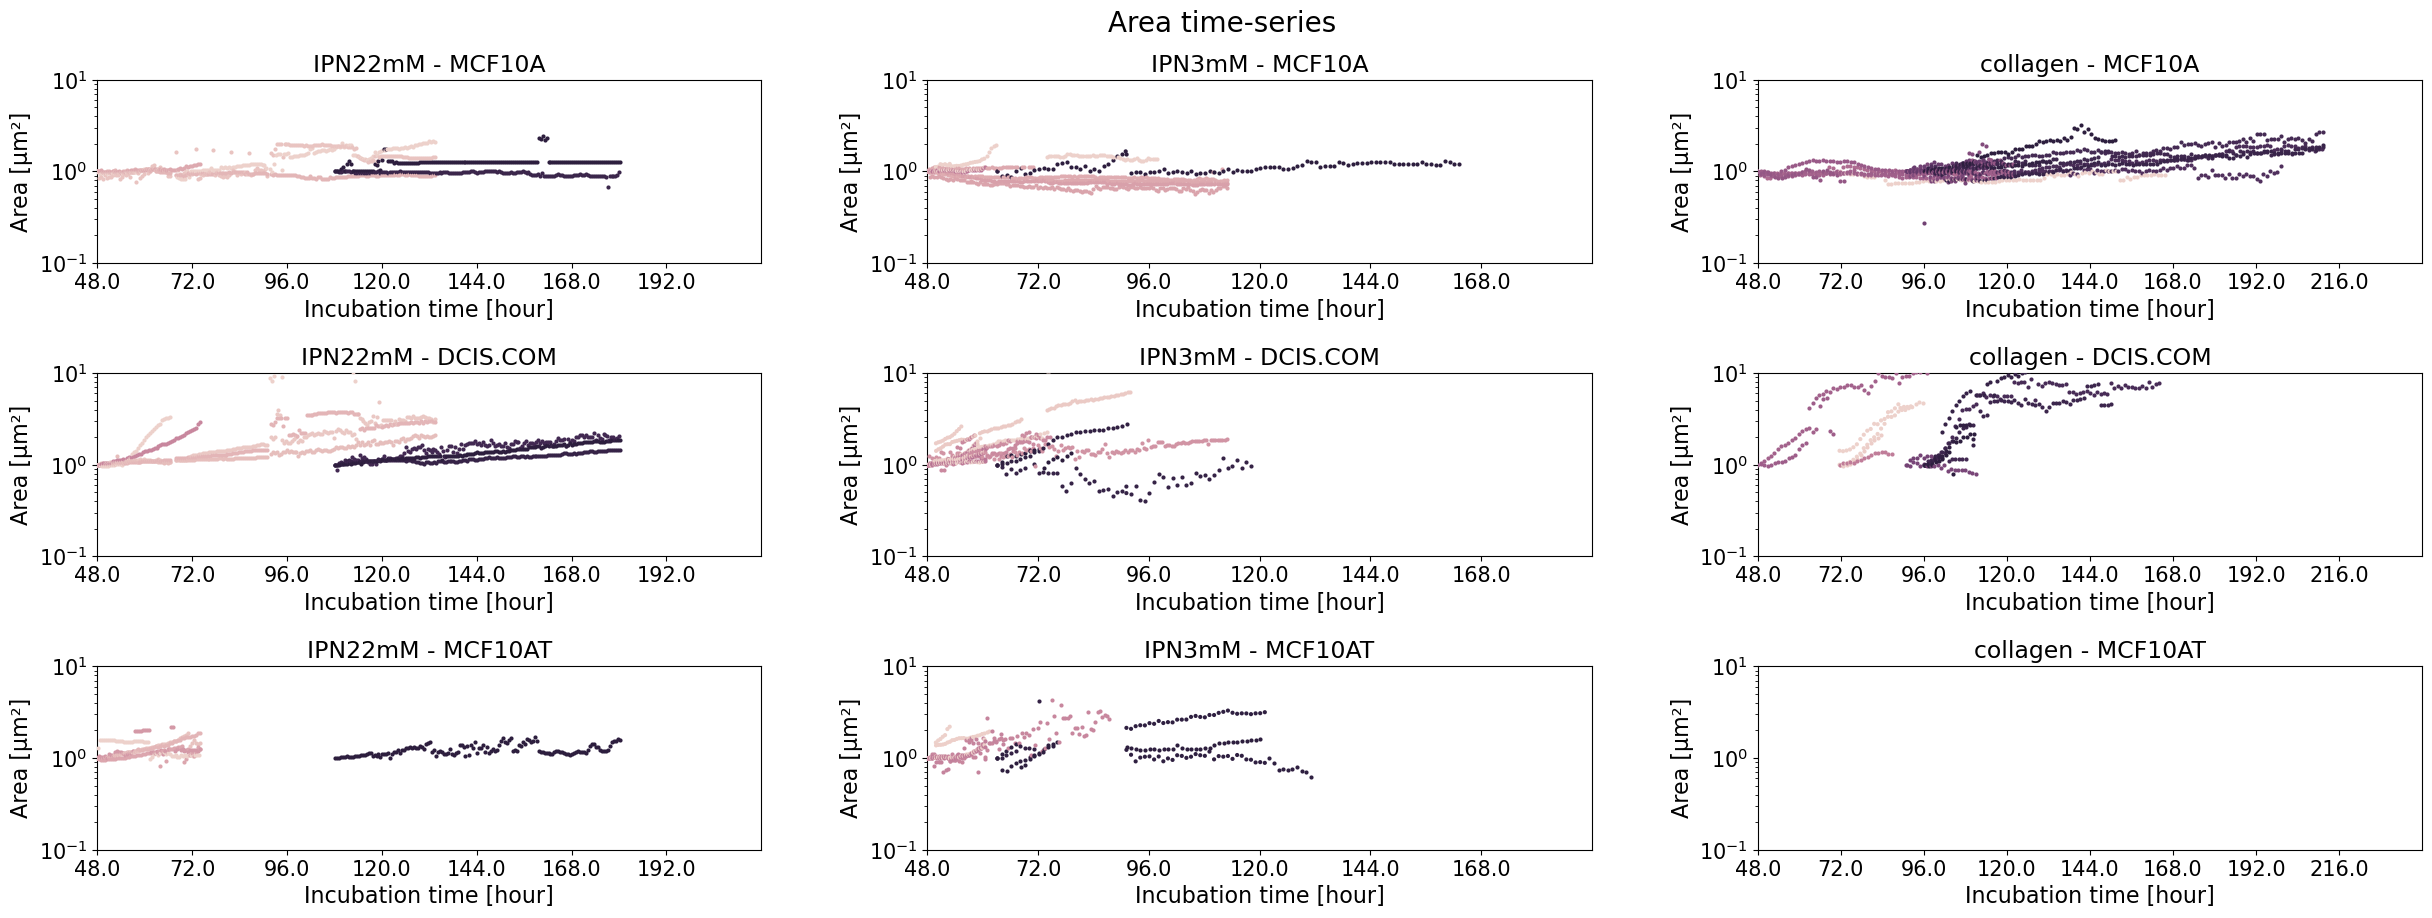

In [16]:
fig, axs = plt.subplots(3, len(unique_materials), figsize=(30, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)
fig.suptitle("Area time-series", fontsize=20, y=0.95)

# To collect legend handles and labels
legend_handles = []
legend_labels = []

for i, unique_material in enumerate(unique_materials):
    specific_df = Exp2[(Exp2['matrix'] == unique_material) & (Exp2['area_µm'] > 0)]

    min_value_all = (specific_df['incubation_time'].min() // 24) * 24  # Latest start time aligned to 24-hour intervals
    max_value_all = (specific_df['incubation_time'].max() // 24 + 2) * 24  # Latest end of timelapses x_max

    times = list(np.arange(min_value_all, max_value_all, 24))  # Ticks' values

    for j, unique_line in enumerate(unique_lines):
        ax = axs[j, i]
        specific_specific_df = specific_df[specific_df['cell_line'] == unique_line]

        sns.swarmplot(data=specific_specific_df, y='normalized', ax=ax, x='incubation_time', 
                      native_scale=True, hue='grouped_id', size=3, marker='o', dodge=True)

        ax.set_xlim(min_value_all, max_value_all)
        ax.set_yscale('log')
        ax.set_ylabel('Area [µm²]', fontsize=16)
        ax.set_xlabel('Incubation time [hour]', fontsize=16)
        ax.set_title(f'{unique_material} - {unique_line}', fontsize=17)
        ax.set_ylim(0.1, 10)
        ax.set_xticks(times)
        ax.set_xticklabels(times)
        ax.tick_params(axis='both', which='major', labelsize=15)  # Major ticks

        # Collect legend handles and labels if not already collected
        if i == 0 and j == 0:
            handles, labels = ax.get_legend_handles_labels()
            legend_handles.extend(handles)
            legend_labels.extend(labels)

        # Remove legends from all subplots to avoid duplication
        ax.get_legend().remove()

# Add a single legend outside the subplots
fig.legend(legend_handles, legend_labels, loc='center right', bbox_to_anchor=(1.05, 0.5), fontsize=16)

plt.savefig(path + '/Time_series.png', dpi=1000)


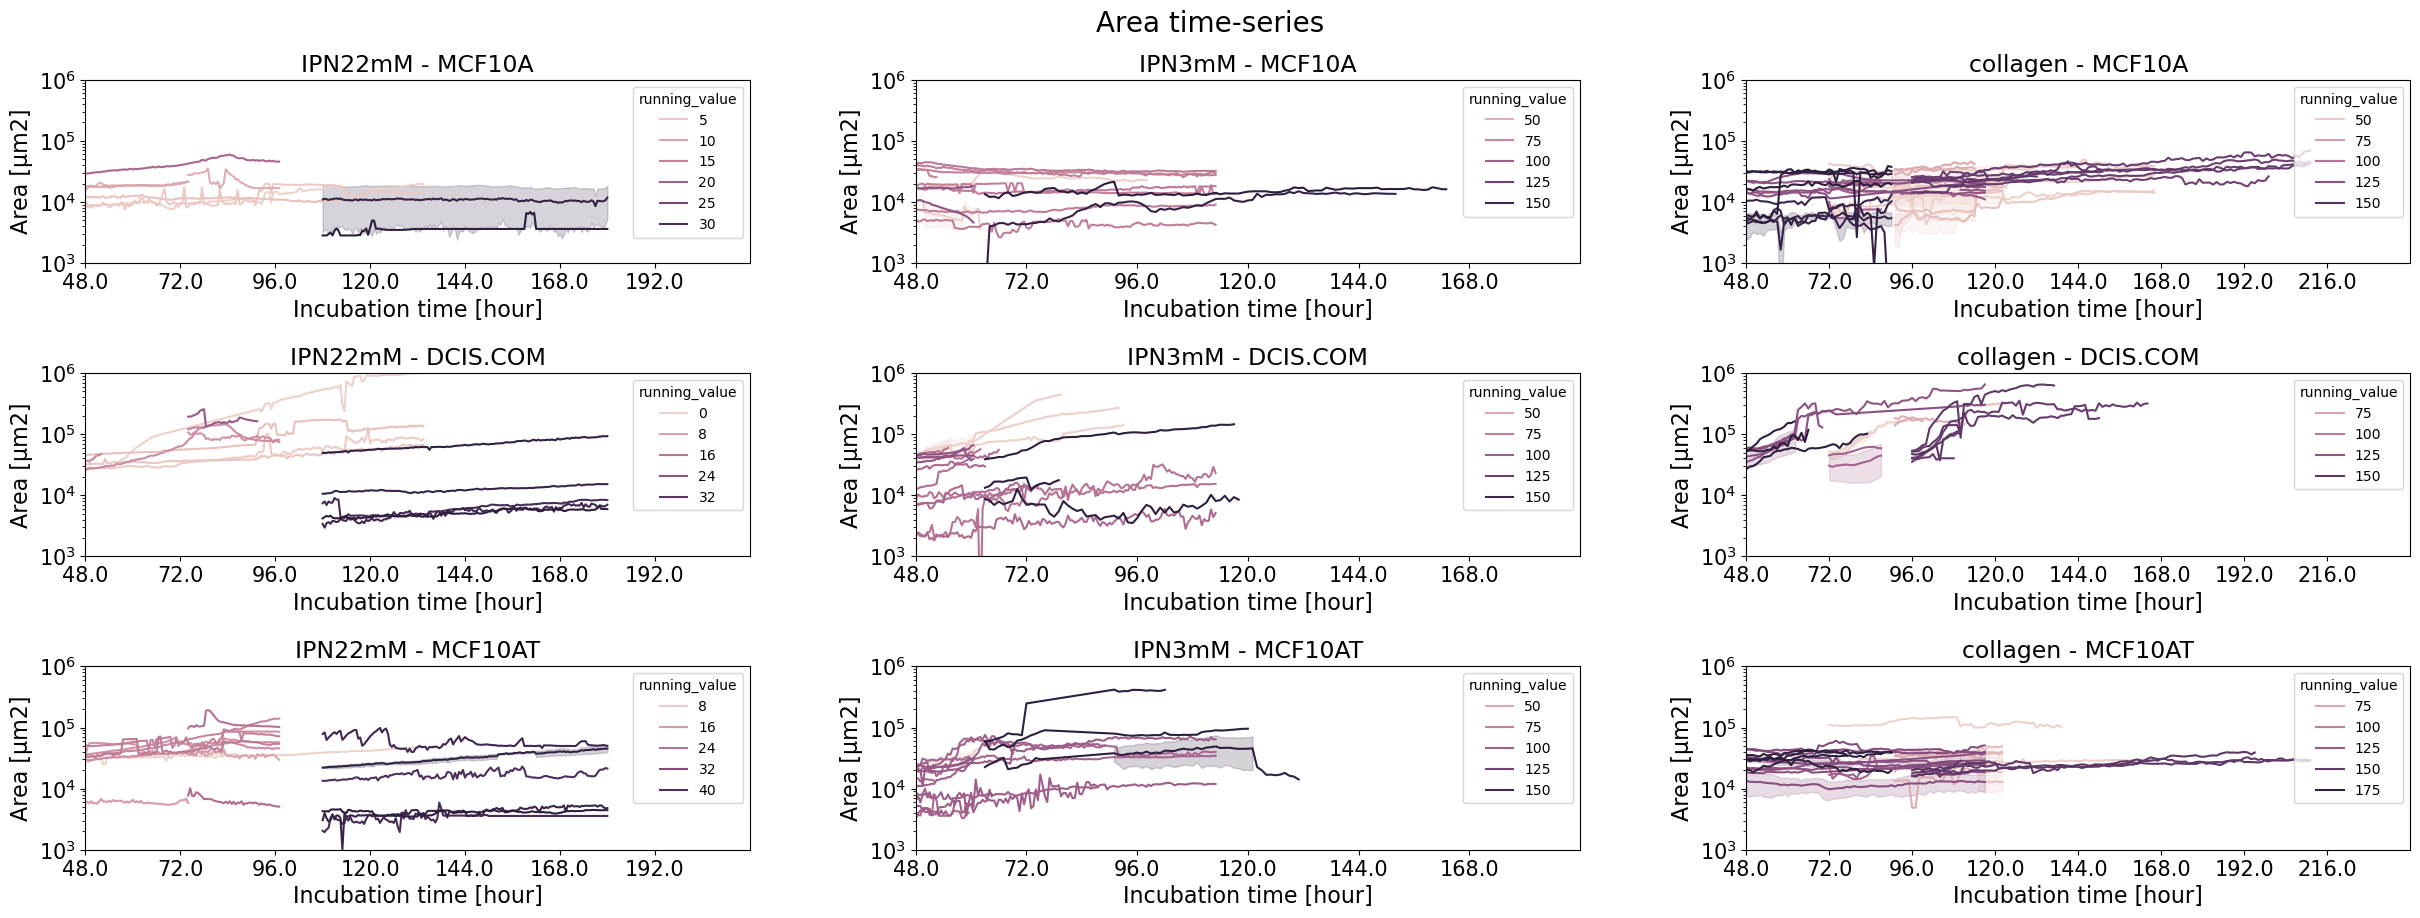

In [24]:
fig, axs = plt.subplots(3, len(unique_materials), figsize=(30,10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)
fig.suptitle("Area time-series", fontsize=20, y=0.95)


for i, unique_material in enumerate(unique_materials):
    specific_df = Exp2[(Exp2['matrix'] == unique_material) & (Exp2['area_µm'] > 0) ]

    min_value_all = (specific_df['incubation_time'].min() // 24) * 24 #latest end of timelpases x_max
    max_value_all = (specific_df['incubation_time'].max() // 24 + 2) * 24 #latest end of timelpases x_max

    times = list(np.arange(min_value_all, max_value_all, 24)) #ticks' values

    
    for j,unique_line in enumerate(unique_lines):
        ax=axs[j,i]
        specific_specific_df = specific_df[(specific_df['cell_line'] == unique_line)]

        #min_value = specific_specific_df['incubation_time'].min() #latest end of timelpases x_max
        #max_value = specific_specific_df['incubation_time'].max() #latest end of timelpases x_max

        #print( f'{unique_material}- {unique_line}; min: {min_value} and max {max_value}')

        sns.lineplot(specific_specific_df, y='area_µm', ax=ax, x='incubation_time', hue='running_value')
        ax.set_xlim(min_value_all, max_value_all)  

        ax.set_yscale('log')

        ax.set_ylabel('Area [µm2]', fontsize= 16)  
        ax.set_xlabel('Incubation time [hour]', fontsize= 16)  

        ax.set_title(f'{unique_material} - {unique_line}', fontsize= 17)
        ax.set_ylim(10**3,10**6)
        ax.set_xticks(times)
        ax.set_xticklabels(times)
        ax.tick_params(axis='both', which='major', labelsize=15)  # Major ticks

    
plt.savefig(path +'/Time_series.png',dpi=1000)

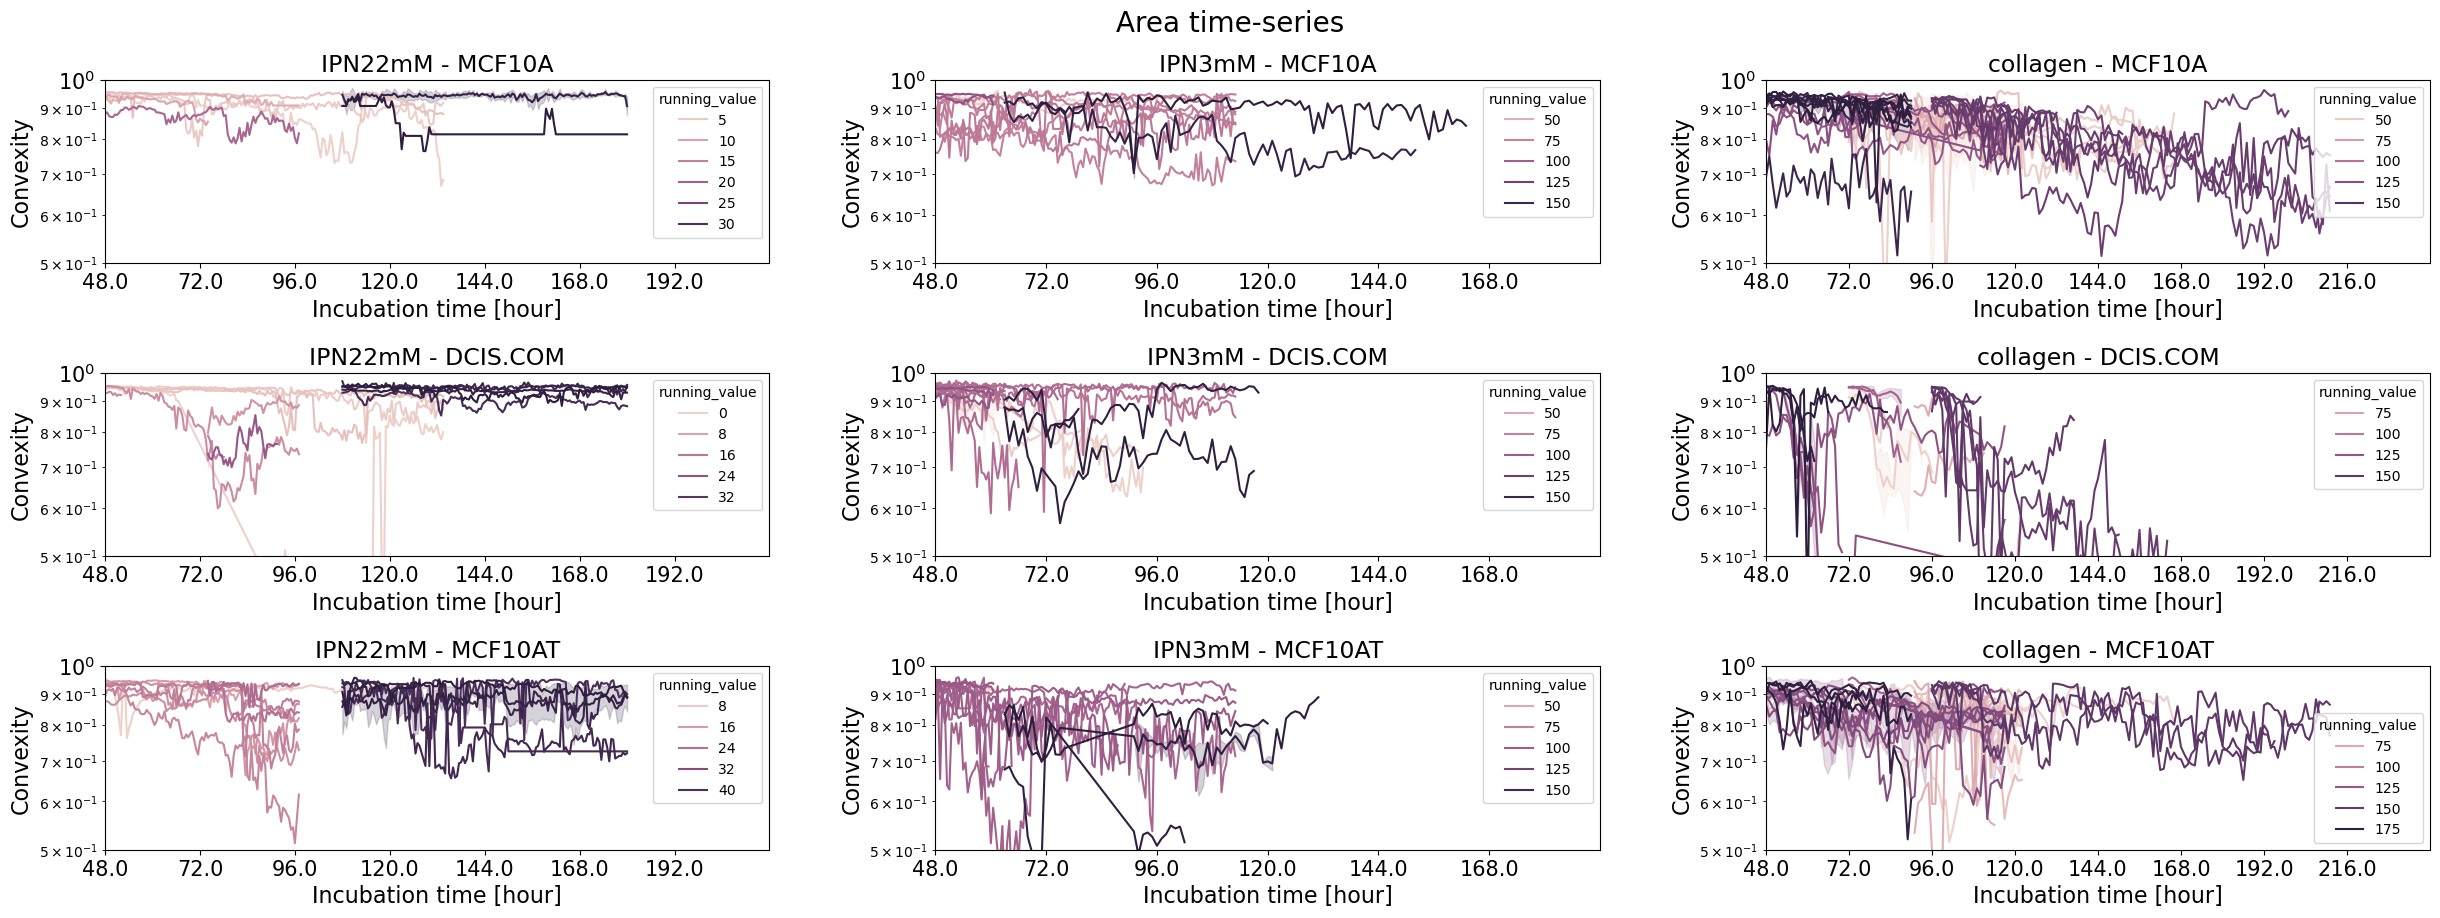

In [30]:
fig, axs = plt.subplots(3, len(unique_materials), figsize=(30,10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)
fig.suptitle("Area time-series", fontsize=20, y=0.95)


for i, unique_material in enumerate(unique_materials):
    specific_df = Exp2[(Exp2['matrix'] == unique_material) & (Exp2['area_µm'] > 0) ]

    min_value_all = (specific_df['incubation_time'].min() // 24) * 24 #latest end of timelpases x_max
    max_value_all = (specific_df['incubation_time'].max() // 24 + 2) * 24 #latest end of timelpases x_max

    times = list(np.arange(min_value_all, max_value_all, 24)) #ticks' values

    
    for j,unique_line in enumerate(unique_lines):
        ax=axs[j,i]
        specific_specific_df = specific_df[(specific_df['cell_line'] == unique_line)]

        #min_value = specific_specific_df['incubation_time'].min() #latest end of timelpases x_max
        #max_value = specific_specific_df['incubation_time'].max() #latest end of timelpases x_max

        #print( f'{unique_material}- {unique_line}; min: {min_value} and max {max_value}')

        sns.lineplot(specific_specific_df, y='convexity_perimeter', ax=ax, x='incubation_time', hue='running_value')
        ax.set_xlim(min_value_all, max_value_all)  

        ax.set_yscale('log')

        ax.set_ylabel('Convexity', fontsize= 16)  
        ax.set_xlabel('Incubation time [hour]', fontsize= 16)  

        ax.set_title(f'{unique_material} - {unique_line}', fontsize= 17)
        ax.set_ylim(0.5,1)
        ax.set_xticks(times)
        ax.set_xticklabels(times)
        ax.tick_params(axis='both', which='major', labelsize=15)  # Major ticks

    
plt.savefig(path +'/Time_series.png',dpi=1000)